# Tweet Emotion Recognition (Deep Learning Project)

This notebook follows the required rubric:
- Dataset validation & statistical analysis
- Visualization (EDA)
- Preprocessing & regularization
- Two models: **from scratch** + **fine-tuned pretrained**
- Evaluation & comparison
- Export artifacts for Django inference app

**Dataset**: `dair-ai/emotion` (Twitter messages labeled with 6 emotions: sadness, joy, love, anger, fear, surprise).

In [2]:
# =========================================================
# Cell 1 — Setup & Reproducibility
# =========================================================
import os, re, string, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keep plots clean & consistent (white bg, black text)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black",
    "axes.titlecolor": "black",
})
# Global config
MODEL_NAME = "distilbert-base-uncased"
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Seed:", SEED)


Seed: 42


In [3]:
# =========================================================
# Cell 2 — Imports
# =========================================================
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
import tf_keras as keras
from tf_keras import layers

from transformers import AutoTokenizer,TFAutoModelForSequenceClassification


## 2.1 Dataset Validation (reference)
We load the dataset and validate schema, splits, missing values, duplicates, label distribution, and basic text statistics.

In [4]:
# =========================================================
# Cell 3 — Load Dataset
# =========================================================
ds = load_dataset("dair-ai/emotion")  # train/validation/test splits
ds


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# =========================================================
# Cell 4 — Convert to pandas + schema checks
# =========================================================
train_df = ds["train"].to_pandas()
val_df   = ds["validation"].to_pandas()
test_df  = ds["test"].to_pandas()

def quick_schema(df, name):
    print(f"\n{name} shape:", df.shape)
    print(df.dtypes)
    print(df.head(3))

quick_schema(train_df, "train")
quick_schema(val_df, "validation")
quick_schema(test_df, "test")



train shape: (16000, 2)
text     object
label     int64
dtype: object
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3

validation shape: (2000, 2)
text     object
label     int64
dtype: object
                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2

test shape: (2000, 2)
text     object
label     int64
dtype: object
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0


In [6]:
# Names in the correct ID order (0..5)
class_names = ds["train"].features["label"].names
print("Classes:", class_names)


Classes: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [7]:
# =========================================================
# Cell 5 — Basic data quality checks
# =========================================================
def data_quality_report(df, name):
    print(f"\n=== {name} ===")
    print("Missing values per column:")
    print(df.isna().sum())
    print("Duplicate rows:", df.duplicated().sum())
    print("Unique labels:", sorted(df["label"].unique()))
    print("Label counts:")
    print(df["label"].value_counts().sort_index())

data_quality_report(train_df, "train")
data_quality_report(val_df, "validation")
data_quality_report(test_df, "test")



=== train ===
Missing values per column:
text     0
label    0
dtype: int64
Duplicate rows: 1
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Label counts:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64

=== validation ===
Missing values per column:
text     0
label    0
dtype: int64
Duplicate rows: 0
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Label counts:
label
0    550
1    704
2    178
3    275
4    212
5     81
Name: count, dtype: int64

=== test ===
Missing values per column:
text     0
label    0
dtype: int64
Duplicate rows: 0
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Label counts:
label
0    581
1    695
2    159
3    275
4    224
5     66
Name: count, dtype: int64


### 2.1.1 Statistical Analysis
For text data, classic numeric `describe()` is limited; we generate *text-derived numeric features* (length, word count) and summarize them per class.

In [8]:
# =========================================================
# Cell 6 — Text-derived numeric features
# =========================================================
def add_text_features(df):
    df = df.copy()
    df["n_chars"] = df["text"].astype(str).str.len()
    df["n_words"] = df["text"].astype(str).str.split().apply(len)
    return df

train_feat = add_text_features(train_df)
val_feat   = add_text_features(val_df)
test_feat  = add_text_features(test_df)

train_feat[["n_chars","n_words"]].describe()


,n_chars,n_words
count,16000.000000,16000.000000
mean,96.845812,19.166313
std,55.904953,10.986905
min,7.000000,2.000000
25%,53.000000,11.000000
50%,86.000000,17.000000
75%,129.000000,25.000000
max,300.000000,66.000000


In [9]:
# =========================================================
# Cell 7 — Feature stats per class (mean/median)
# =========================================================
stats_per_class = (
    train_feat
    .groupby("label")[["n_chars","n_words"]]
    .agg(["mean","median","std","min","max"])
)
stats_per_class


n_chars                               n_words                        \
             mean median        std min  max       mean median        std min   
label                                                                           
0       92.550579   80.0  56.085306   7  299  18.361980   16.0  11.037223   2   
1       98.554457   89.0  55.032087   9  300  19.498135   18.0  10.772118   2   
2      104.033742   94.0  55.145913  13  299  20.700153   19.0  10.827956   3   
3       96.911533   85.0  57.677478   9  298  19.229736   17.0  11.426926   2   
4       96.123903   85.0  55.187941   9  296  18.844605   17.0  10.890188   2   
5      101.676573   88.5  57.245763  12  287  19.970280   18.0  11.031756   3   

           
      max  
label      
0      66  
1      64  
2      63  
3      62  
4      60  
5      60

#### 2.1.1.1 Correlations (if applicable)
Labels are categorical, so Pearson correlation isn't directly meaningful.
Instead, we compute **Cramér’s V** between binned text length and label as a simple association measure.

In [10]:
# =========================================================
# Cell 8 — Cramér’s V (binned length vs label)
# =========================================================
import scipy.stats as ss

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k-1, r-1)))

# Bin by quantiles to avoid arbitrary thresholds
train_feat["len_bin"] = pd.qcut(train_feat["n_chars"], q=5, duplicates="drop")
ct = pd.crosstab(train_feat["len_bin"], train_feat["label"])
v = cramers_v(ct.values)

print("Cramér’s V (len_bin vs label):", round(float(v), 4))
ct


Cramér’s V (len_bin vs label): 0.0425


label,0,1,2,3,4,5
len_bin,,,,,,
"(6.999, 47.0]",1084,971,191,482,389,105
"(47.0, 73.0]",1033,1100,255,399,421,100
"(73.0, 100.0]",824,1068,270,422,374,123
"(100.0, 140.0]",888,1144,290,395,377,120
"(140.0, 300.0]",837,1079,298,461,376,124


### 2.1.2 Data Cleaning
We implement conservative cleaning:
- Strip URLs, mentions, repeated spaces
- Keep hashtags' text (remove # only)
- Keep emojis/punctuation for the pretrained model (often helpful)

We **do not** impute missing labels/text because the dataset should not contain them; if any appear, we drop them.

In [11]:
# =========================================================
# Cell 9 — Cleaning utilities
# =========================================================
URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text_basic(t: str) -> str:
    t = str(t)
    t = URL_RE.sub("", t)
    t = MENTION_RE.sub("", t)
    t = t.replace("#", "")  # keep hashtag word, drop the '#'
    t = MULTISPACE_RE.sub(" ", t).strip()
    return t

def clean_df(df):
    df = df.copy()
    df = df.dropna(subset=["text","label"])
    df["text_clean"] = df["text"].apply(clean_text_basic)
    return df

train_c = clean_df(train_df)
val_c   = clean_df(val_df)
test_c  = clean_df(test_df)

print(train_c[["text","text_clean","label"]].head(3))


                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   

                                          text_clean  label  
0                            i didnt feel humiliated      0  
1  i can go from feeling so hopeless to so damned...      0  
2   im grabbing a minute to post i feel greedy wrong      3  


## 2.2 Visualization
EDA: univariate (label distribution), bivariate (length vs label), and multivariate-ish (length+word count pair plots).

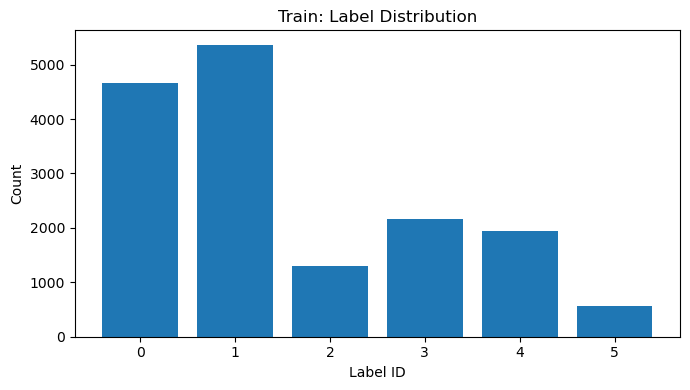

In [12]:
# =========================================================
# Cell 10 — Label distribution (train)
# =========================================================
label_counts = train_c["label"].value_counts().sort_index()

plt.figure(figsize=(7,4))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Train: Label Distribution")
plt.xlabel("Label ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


C:\Users\Hassan-PC\AppData\Local\Temp\ipykernel_23604\3107090552.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


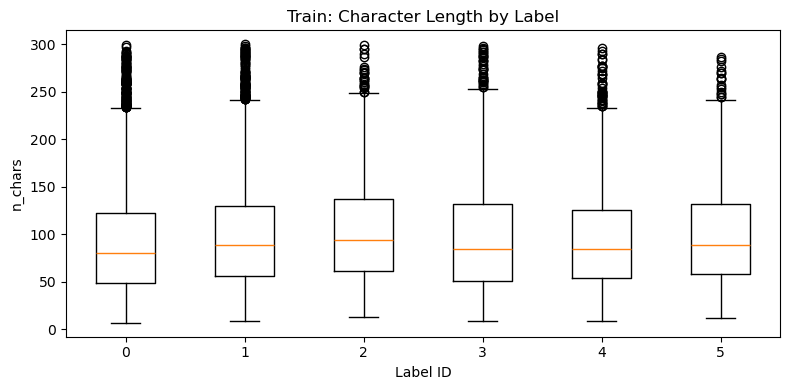

In [13]:
# =========================================================
# Cell 11 — Text length by label (boxplots)
# =========================================================
train_f = add_text_features(train_c)

plt.figure(figsize=(8,4))
plt.boxplot(
    [train_f.loc[train_f["label"]==i, "n_chars"] for i in sorted(train_f["label"].unique())],
    labels=[str(i) for i in sorted(train_f["label"].unique())]
)
plt.title("Train: Character Length by Label")
plt.xlabel("Label ID")
plt.ylabel("n_chars")
plt.tight_layout()
plt.show()


In [14]:
# =========================================================
# Cell 12 — Number of inputs per class (train)
# =========================================================
# Same as label distribution, but explicitly stated for rubric
inputs_per_class = train_c["label"].value_counts().sort_index().rename("n_samples")
inputs_per_class.to_frame()


,n_samples
label,
0,4666
1,5362
2,1304
3,2159
4,1937
5,572


## 2.3 Preprocessing
We build two pipelines:
1) **From-scratch**: TF‑IDF + dense network (Keras) (includes L1/L2, dropout, batch norm)
2) **Pretrained**: DistilBERT fine‑tuning

### 2.3.1 Feature normalization
TF‑IDF is already normalized-ish; we still apply **StandardScaler(with_mean=False)** for sparse matrices.

### 2.3.2 Regularization
- L2 (weight decay) in Dense layers
- Dropout
- (Optional) simple text augmentation for the scratch model

In [15]:
# =========================================================
# Cell 13 — Train/Val/Test arrays
# =========================================================
X_train = train_c["text_clean"].tolist()
y_train = train_c["label"].to_numpy()

X_val = val_c["text_clean"].tolist()
y_val = val_c["label"].to_numpy()

X_test = test_c["text_clean"].tolist()
y_test = test_c["label"].to_numpy()

num_classes = int(train_c["label"].nunique())
print("num_classes:", num_classes)


num_classes: 6


In [16]:
# =========================================================
# Cell 14 — OPTIONAL simple augmentation (scratch model only)
# =========================================================
# NOTE: This is intentionally minimal (fast + no external thesaurus).
# It performs random word deletion with low probability.
def random_deletion(sentence, p=0.08):
    words = sentence.split()
    if len(words) <= 3:
        return sentence
    kept = [w for w in words if random.random() > p]
    if len(kept) == 0:
        kept = [random.choice(words)]
    return " ".join(kept)

USE_AUG = False  # set True for bonus experimentation

if USE_AUG:
    X_train_aug = [random_deletion(s) for s in X_train]
    X_train_final = X_train + X_train_aug
    y_train_final = np.concatenate([y_train, y_train])
else:
    X_train_final = X_train
    y_train_final = y_train

print("Train size (final):", len(X_train_final))


Train size (final): 16000


## 2.4 Neural Network Construction
### Model A (From scratch): TF‑IDF → Dense NN (Keras)
- Includes **BatchNorm**, **Dropout**, **L1/L2**

### Model B (Pretrained): DistilBERT fine‑tuning
- Tokenizer + Transformer classifier head
- Train with Keras `fit()`

In [17]:
# =========================================================
# Cell 15 — Vectorize + Scale (scratch model)
# =========================================================
tfidf = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1,2),
    min_df=2
)

scaler = StandardScaler(with_mean=False)  # sparse-friendly

Xtr_tfidf = tfidf.fit_transform(X_train_final)
Xva_tfidf = tfidf.transform(X_val)
Xte_tfidf = tfidf.transform(X_test)

Xtr_scaled = scaler.fit_transform(Xtr_tfidf).astype(np.float32)
Xva_scaled = scaler.transform(Xva_tfidf).astype(np.float32)
Xte_scaled = scaler.transform(Xte_tfidf).astype(np.float32)

print("TF-IDF shapes:", Xtr_scaled.shape, Xva_scaled.shape, Xte_scaled.shape)


TF-IDF shapes: (16000, 32995) (2000, 32995) (2000, 32995)


In [18]:
# =========================================================
# Cell 16 — Build scratch Keras model
# =========================================================
def make_scratch_model(input_dim, num_classes, l1=0.0, l2=1e-4, dropout=0.4):
    reg = keras.regularizers.L1L2(l1=l1, l2=l2)
    inputs = keras.Input(shape=(input_dim,), name="tfidf_features")

    x = layers.Dense(512, kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)          # 2.4.0.1
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)              # 2.4.0.2

    x = layers.Dense(256, kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="scratch_tfidf_dense")

scratch_model = make_scratch_model(Xtr_scaled.shape[1], num_classes, l1=0.0, l2=1e-4, dropout=0.35)
scratch_model.summary()



Model: "scratch_tfidf_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfidf_features (InputLayer  [(None, 32995)]           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               16893952  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)      

In [19]:
# =========================================================
# Cell 17 — Compile & Train scratch model
# =========================================================
scratch_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

history_scratch = scratch_model.fit(
    Xtr_scaled, y_train_final,
    validation_data=(Xva_scaled, y_val),
    epochs=20,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20


63/63 [==============================] - 14s 147ms/step - loss: 1.3527 - accuracy: 0.5551 - val_loss: 0.9262 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 9s 141ms/step - loss: 0.3652 - accuracy: 0.9524 - val_loss: 0.9566 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9921
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 9s 142ms/step - loss: 0.2151 - accuracy: 0.9921 - val_loss: 0.9770 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 9s 143ms/step - loss: 0.1875 - accuracy: 0.9964 - val_loss: 0.9725 - val_accuracy: 0.7210 - lr: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [20]:
# =========================================================
# Cell 18 — Predict & Evaluate scratch model
# =========================================================
scratch_train_loss, scratch_train_acc = scratch_model.evaluate(Xtr_scaled, y_train_final, verbose=0)
scratch_test_loss,  scratch_test_acc  = scratch_model.evaluate(Xte_scaled, y_test, verbose=0)

y_pred_scratch = scratch_model.predict(Xte_scaled, verbose=0).argmax(axis=1)

print("Scratch Train Acc:", round(float(scratch_train_acc), 4), "| Train Loss:", round(float(scratch_train_loss), 4))
print("Scratch Test  Acc:", round(float(scratch_test_acc), 4),  "| Test  Loss:", round(float(scratch_test_loss), 4))
print("\nClassification Report (scratch):\n", classification_report(y_test, y_pred_scratch))


Scratch Train Acc: 0.9847 | Train Loss: 0.2286
Scratch Test  Acc: 0.725 | Test  Loss: 0.9492

Classification Report (scratch):
               precision    recall  f1-score   support

           0       0.77      0.76      0.77       581
           1       0.77      0.79      0.78       695
           2       0.52      0.57      0.54       159
           3       0.70      0.72      0.71       275
           4       0.68      0.64      0.66       224
           5       0.58      0.38      0.46        66

    accuracy                           0.72      2000
   macro avg       0.67      0.64      0.65      2000
weighted avg       0.72      0.72      0.72      2000



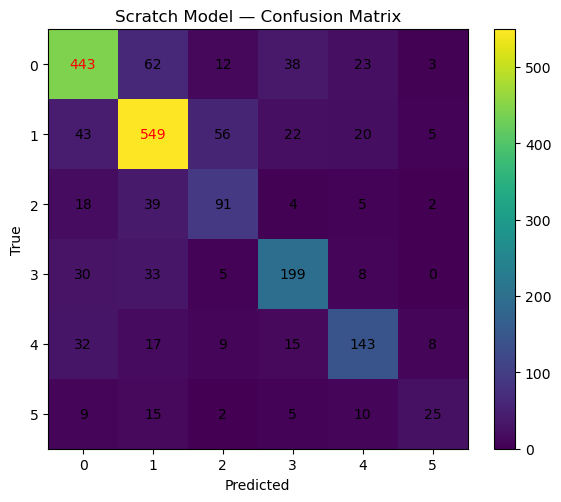

In [21]:
# =========================================================
# Cell 19 — Confusion Matrix (scratch) (black/red)
# =========================================================
cm = confusion_matrix(y_test, y_pred_scratch)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")  # default colormap is fine; we annotate in black/red
plt.title("Scratch Model — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

thresh = cm.max() * 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "red" if cm[i, j] > thresh else "black"
        plt.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.tight_layout()
plt.show()


### Model B: Fine-tune a pretrained Transformer
We use **DistilBERT** as a lightweight baseline. (You can switch to `cardiffnlp/twitter-roberta-base` for stronger tweet-specific performance if your environment can handle it.)

In [22]:
# =========================================================
# Cell 20 — Tokenization
# =========================================================
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 96

def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

tok_train = tokenize_texts(train_c["text_clean"])
tok_val   = tokenize_texts(val_c["text_clean"])
tok_test  = tokenize_texts(test_c["text_clean"])

y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val_tf   = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test_tf  = tf.convert_to_tensor(y_test, dtype=tf.int32)

print({k: v.shape for k,v in tok_train.items()})


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


{'input_ids': TensorShape([16000, 87]), 'attention_mask': TensorShape([16000, 87])}


In [23]:
MODEL_NAME = "distilbert-base-uncased"

pretrained_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    use_safetensors=False  # keep this to avoid your earlier safetensors issue
)

pretrained_model.summary()


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_21 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# =========================================================
# Cell 22 — Compile & Fine-tune
# =========================================================
# Keras compile
pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

callbacks_tf = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1),
]

history_pretrained = pretrained_model.fit(
    x=dict(tok_train),
    y=y_train_tf,
    validation_data=(dict(tok_val), y_val_tf),
    epochs=3,
    batch_size=32,
    callbacks=callbacks_tf,
    verbose=1
)


Epoch 1/3
125/500 [======>.......................] - ETA: 15:10 - loss: 1.2422 - accuracy: 0.5555

KeyboardInterrupt: 

In [25]:
# Train ONLY the classification head (freeze the DistilBERT encoder)
pretrained_model.distilbert.trainable = False

# Sanity check: should be only a small number of trainable vars now
print("Trainable variables:", len(pretrained_model.trainable_variables))
for v in pretrained_model.trainable_variables[:10]:
    print(v.name)


Trainable variables: 4
tf_distil_bert_for_sequence_classification/pre_classifier/kernel:0
tf_distil_bert_for_sequence_classification/pre_classifier/bias:0
tf_distil_bert_for_sequence_classification/classifier/kernel:0
tf_distil_bert_for_sequence_classification/classifier/bias:0


In [26]:
pretrained_model.distilbert.trainable = False
pretrained_model.distilbert.transformer.layer[-1].trainable = True

In [ ]:
# =========================================================
# Cell 23 — Predict & Evaluate pretrained model
# =========================================================
train_eval = pretrained_model.evaluate(dict(tok_train), y_train_tf, verbose=0)
test_eval  = pretrained_model.evaluate(dict(tok_test),  y_test_tf,  verbose=0)

# train_eval = [loss, acc]
pre_train_loss, pre_train_acc = float(train_eval[0]), float(train_eval[1])
pre_test_loss,  pre_test_acc  = float(test_eval[0]),  float(test_eval[1])

logits = pretrained_model.predict(dict(tok_test), verbose=0).logits
y_pred_pre = np.argmax(logits, axis=1)

print("Pretrained Train Acc:", round(pre_train_acc, 4), "| Train Loss:", round(pre_train_loss, 4))
print("Pretrained Test  Acc:", round(pre_test_acc, 4),  "| Test  Loss:", round(pre_test_loss, 4))
print("\nClassification Report (pretrained):\n", classification_report(y_test, y_pred_pre))


In [ ]:
# =========================================================
# Cell 24 — Comparison Table
# =========================================================
comparison = pd.DataFrame([
    {"model": "scratch_tfidf_dense", "train_acc": scratch_train_acc, "train_loss": scratch_train_loss, "test_acc": scratch_test_acc, "test_loss": scratch_test_loss},
    {"model": f"finetuned_{MODEL_NAME}", "train_acc": pre_train_acc, "train_loss": pre_train_loss, "test_acc": pre_test_acc, "test_loss": pre_test_loss},
])

comparison


,model,train_acc,train_loss,test_acc,test_loss
0,scratch_tfidf_dense,0.984187,0.229838,0.7155,0.948398
1,finetuned_distilbert-base-uncased,0.966313,0.075284,0.9305,0.142886


## 2.5 Evaluation Metrics
Reported:
- Training Accuracy + Loss
- Test Accuracy + Loss
- Confusion matrix & classification report

## Export artifacts for deployment
We save the tokenizer + fine‑tuned transformer (recommended for inference).

In [ ]:
# =========================================================
# Cell 25 — Save artifacts for Django inference app
# =========================================================
EXPORT_DIR = "export_emotion_model"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Save HF tokenizer + TF model
tokenizer.save_pretrained(EXPORT_DIR)
pretrained_model.save_pretrained(EXPORT_DIR)

# Save label mapping (important for inference)
label_id_to_name = {0:"sadness", 1:"joy", 2:"love", 3:"anger", 4:"fear", 5:"surprise"}
with open(os.path.join(EXPORT_DIR, "label_map.json"), "w", encoding="utf-8") as f:
    json.dump(label_id_to_name, f, ensure_ascii=False, indent=2)

print("Saved to:", EXPORT_DIR)


Saved to: export_emotion_model


## Notebook Insights
- Compare scratch vs pretrained: pretrained should usually win on test accuracy due to richer language representations.
- If scratch competes closely, it often means the dataset is easy / label signal is strong, or fine-tuning was too short.
- Main failure modes: confusion among similar emotions (e.g., joy vs love; sadness vs fear).

Next: Deploy with Django using the exported `export_emotion_model/` folder.

- Adam agmad 3l4an byst5dm step size/parameter